In [ ]:
# standard libs
import os
import math
import time

import numpy as np

# imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set_theme()

# progress bar
from tqdm.auto import tqdm

/tmp/ipykernel_3865372/943404081.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")


# Jax as NumPy on accelerators

In [2]:
import jax
import jax.numpy as jnp

print("Using jax", jax.__version__)

Using jax 0.4.37


## Device Arrays

In [3]:
a = jnp.zeros((2, 5), dtype=jnp.float32)
print(a)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


In [5]:
b.__class__

jaxlib.xla_extension.ArrayImpl

In [6]:
b.device

CudaDevice(id=0)

In [7]:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)

<class 'numpy.ndarray'>


In [8]:
b_gpu = jax.device_put(b_cpu)
print(f"Device put: {b_gpu.__class__} on {b_gpu.device}")

Device put: <class 'jaxlib.xla_extension.ArrayImpl'> on cuda:0


In [9]:
b_cpu + b_gpu, (b_cpu + b_gpu).device

(Array([ 0,  2,  4,  6,  8, 10], dtype=int32), CudaDevice(id=0))

In [10]:
jax.devices()

[CudaDevice(id=0)]

## [JAX - Asynchronous Dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html)

In [11]:
out = jnp.matmul(b, b)

## Immutable tensors: Pure Function Language

However, we said that JAX is very efficient. Isn’t creating a new array in this case the opposite? While it is indeed less efficient, it can made much more efficient with JAX’s just-in-time compilation. The compiler can recognize unnecessary array duplications, and replace them with in-place operations again. More on the just-in-time compilation later!

In [12]:
b_new = b.at[0].set(1)  # returns a new array
print("Original Array:", b)
print("Changed Array:", b_new)

Original Array: [0 1 2 3 4 5]
Changed Array: [1 1 2 3 4 5]


## Pseudo Random Numbers in JAX: For Pure Function

In libraries like NumPy and PyTorch, the random number generator are controlled by a seed, which we set initially to obtain the same samples every time we run the code (this is why the numbers are not truly random, hence “pseudo”-random). However, if we call np.random.normal() 5 times consecutively, we will get 5 different numbers since every execution changes the state/seed of the pseudo random number generation (PRNG). In JAX, if we would try to generate a random number with this approach, a function creating pseudo-random number would have an effect outside of it. To prevent this, JAX takes a different approach by explicitly passing and iterating the PRNG state. First, let’s create a PRNG for the seed 42:

In [13]:
rng = jax.random.PRNGKey(42)

In [14]:
# A non-desirable way of generating pseudo-random numbers...
jax_random_number_1 = jax.random.normal(rng)
jax_random_number_2 = jax.random.normal(rng)
print("JAX - Random number 1:", jax_random_number_1)
print("JAX - Random number 2:", jax_random_number_2)

# Typical random numbers in NumPy
np.random.seed(42)
np_random_number_1 = np.random.normal()
np_random_number_2 = np.random.normal()
print("NumPy - Random number 1:", np_random_number_1)
print("NumPy - Random number 2:", np_random_number_2)

JAX - Random number 1: -0.18471177
JAX - Random number 2: -0.18471177
NumPy - Random number 1: 0.4967141530112327
NumPy - Random number 2: -0.13826430117118466


In general, you want to split the PRNG key every time before generating a pseudo-number, to prevent accidentally obtaining the exact same numbers (for instance, sampling the exact same dropout mask every time you run the network makes dropout itself quite useless…).

In [15]:
rng, subkey1, subkey2 = jax.random.split(rng, num=3)  # We create 3 new keys
jax_random_number_1 = jax.random.normal(subkey1)
jax_random_number_2 = jax.random.normal(subkey2)
print("JAX new - Random number 1:", jax_random_number_1)
print("JAX new - Random number 2:", jax_random_number_2)

JAX new - Random number 1: 0.107961535
JAX new - Random number 2: -1.2226542


# Function Transformations with Jaxpr

The most important difference, and in some sense the root of all the rest, is that JAX is designed to be functional, as in functional programming. The reason behind this is that the kinds of program transformations that JAX enables are much more feasible in functional-style programs. […] The important feature of functional programming to grok when working with JAX is very simple: don’t write code with side-effects.

Essentially, we want to write our main code of JAX in functions that do not affect anything else besides its outputs. For instance, we do not want to change input arrays in-place, or access global variables. While this might seem limiting at first, you get used to this quite quickly and most JAX functions that need to fulfill these constraints can be written this way without problems. Note that not all possible functions in training a neural network need to fulfill the constraints. For instance, loading or saving of models, the logging, or the data generation can be done in naive functions. Only the network execution, which we want to do very efficiently on our accelerator (GPU or TPU), should strictly follow these constraints.

``jaxpr``, conceptually, you can think of any operation that JAX does on a function, as first trace-specializing the Python function to be transformed into a small and well-behaved intermediate form. This means that we check which operations are performed on which array, and what shapes the arrays are. Based on this representation, JAX then interprets the function with transformation-specific interpretation rules, which includes automatic differentiation or compiling a function in XLA to efficiently use the accelerator.

In [16]:
def simple_graph(x):
    x = x + 2
    x = x**2
    x = x + 3
    y = x.mean()
    return y


inp = jnp.arange(3, dtype=jnp.float32)
print("Input:", inp)
print("Output:", simple_graph(inp))

Input: [0. 1. 2.]
Output: 12.666667


In [17]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

A jaxpr representation follows the structure:
```
jaxpr ::= { lambda Var* ; Var+.
            let Eqn*
            in  [Expr+] }
```

where `Var*` are constants and `Var+` are input arguments. In the cell above, this is `a:f32[3]`, i.e. an array of shape 3 with type `jnp.float32` (`inp`). The list of equations, `Eqn*`, define the intermediate results of the function. You can see that each operation in `simple_graph` is translated to a corresponding equation, like `x = x + 2` is translated to `b:f32[3] = add a 2.0`. Furthermore, you see the specialization of the operations on the input shape, like `x.mean()` being replacing in `e` and `f` with summing and dividing by 3. Finally, `Expr+` in the jaxpr representation are the outputs of the functions. In the example, this is `f`, i.e. the final result of the function. Based on these atomic operations, JAX offers all kind of function transformations, of which we will discuss the most important ones later in this section. Hence, you can consider the jaxpr representation is an intermediate compilation stage of JAX. What happens if we actually try to look at the jaxpr representation of a function with side-effect? Let’s consider the following function, which, as an illustrative example, appends the input to a global list:

In [ ]:
global_list = []


# invalid function with side-effect
def norm(x):
    global_list.append(x)  # unavailable
    x = x**2
    n = x.sum()
    n = jnp.sqrt(n)
    return n


jax.make_jaxpr(norm)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

## Automatic Differentiation

In frameworks like PyTorch with a dynamic computation graph, we would compute the gradients based on the loss tensor itself, e.g. by calling loss.backward(). However, JAX directly works with functions. Instead of backpropagating gradients through tensors, JAX takes as input a function, and outputs another function which directly calculates the gradients for it. While this might seem quite different to what you are used to from other frameworks, it is quite intuitive: your gradient of parameters is really a function of parameters and data.

In [ ]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print("Gradient", gradients)

Gradient [1.3333334 2.        2.6666667]


In [20]:
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(3,)
      sharding=None
    ] h
    j:f32[3] = mul i e
  in (j,) }

In [21]:
# get both grad and value
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(Array(12.666667, dtype=float32),
 Array([1.3333334, 2.       , 2.6666667], dtype=float32))

More topics like multi-input grad and PyTree will be mentioned later

## Jit: Just-In-Time

Computing the gradient of a scalar is unnecessary. Finding such cases to improve efficiency and optimizing the code to take full advantage of the available accelerator hardware is one of the big selling points of JAX. It achieves that by compiling functions just-in-time with XLA (Accelerated Linear Algebra), using their jaxpr representation. Thereby, XLA fuses operations to reduce execution time of short-lived operations and eliminates intermediate storage buffers where not needed. 

Since the jaxpr representation of a function depends on the input shape, the compilation is started once we put the first input in. However, note that this also means that for every different shape we want to run the function, a new XLA compilation is needed. This is why it is recommended to use padding in cases where your input shape strongly varies (we revisit this topic in the final section of this tutorial).

There are situations in which applying jit to a function is not straight-forward, for instance, if an input argument cannot be traced, or you need to use loops that depend on input arguments. To keep the tutorial simple, and since most neural network training functions do not run into these issues, we do not discuss such special cases here. Instead, we refer to the section on just-in-time compilation in the great tutorials of JAX 101 Tutorial, JAX Quickstart, and Thinking in JAX.

In [23]:
jitted_function = jax.jit(simple_graph)  # or use @jax.jit decorator

In [ ]:
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (1000,))
# run the jitted function once to start compilation
_ = jitted_function(large_input)

In [26]:
%%timeit
simple_graph(large_input).block_until_ready()

125 μs ± 3.2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
%%timeit
jitted_function(large_input).block_until_ready()

18.5 μs ± 1.2 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)

In [30]:
%%timeit
grad_function(large_input).block_until_ready()

1.44 ms ± 34.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

16.6 μs ± 1.31 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Implementating a Neural Network with Flax

Similarly to PyTorch’s `torch.nn` package, there exist neural network libraries based on JAX which provide such basic functionality. A (non-exclusive) collection of them are:

[Flax](https://flax.readthedocs.io/en/latest/index.html), started by the Google Brain Team, focuses on flexibility and clarity.

[Haiku](https://dm-haiku.readthedocs.io/en/latest/), from DeepMind, focuses on simplicity and compositionality.

[Trax](https://github.com/google/trax), maintained by the Google Brain Team, provides solutions for common training tasks

[Equinox](https://github.com/patrick-kidger/equinox), created by Patrick Kidger and Cristian Garcia, implements neural networks as callable PyTrees

[Jraph](https://github.com/deepmind/jraph), from DeepMind, is a graph neural network library (similar to PyTorch Geometric)

We will use flax to learn an XOR function.

In [32]:
from flax import linen as nn

## The model

In [33]:
class MyModule(nn.Module):
    # Some dataclass attributes, like hidden dimension, number of layers, etc. of the form:
    # varname : vartype

    def setup(self):
        # Flax uses "lazy" initialization. This function is called once before you
        # call the model, or try to access attributes. In here, define your submodules etc.
        pass

    def __call__(self, x):
        # Function for performing the calculation of the module.
        pass

In [ ]:
class SimpleClassifier(nn.Module):
    num_hidden: int  # Number of hidden neurons
    num_outputs: int  # Number of output neurons

    def setup(self):
        # Create the modules we need to build the network
        # nn.Dense is a linear layer
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

One thing you may notice is that usually, all layers that we define in `setup` are also used in the `__call__` function. To reduce the code overhead, Flax provides an alternative, more compact network creation with `nn.compact`. With that, we can remove the `setup` function and instead our model as:

In [ ]:
class SimpleClassifierCompact(nn.Module):
    num_hidden: int  # Number of hidden neurons
    num_outputs: int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In the following tutorials, we will mostly use the compact version, but occasionally come back to the explicit setup function where necessary. For instance, if we define more functions on a module besides `__call__` and want to reuse some modules, it is recommended to use the `setup` version (see the [Flax documentation](https://flax.readthedocs.io/en/latest/design_notes/setup_or_nncompact.html) for some pros and cons for both methods).

For the examples in this notebook, we will use a tiny neural network with two input neurons and eight hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.



In [36]:
model = SimpleClassifierCompact(num_hidden=8, num_outputs=1)
# Printing the model shows its attributes
print(model)

SimpleClassifierCompact(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


At this stage, the model has no parameters initialized. To do this, let’s create a random input of our dataset, and apply the init function:

In [37]:
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))  # Batch size 8, input size 2
# Initialize the model
params = model.init(init_rng, inp)
print(params)

{'params': {'Dense_0': {'kernel': Array([[-1.3683505e+00, -1.2959253e+00,  5.0286078e-01,  1.0897663e+00,
        -6.7686325e-01,  3.5703367e-01,  1.3726141e+00, -1.5955209e+00],
       [-3.9651689e-01,  6.3335317e-01, -1.0827602e-01,  1.0729686e+00,
         7.1337450e-01,  1.1620057e-03, -5.6069337e-02, -8.2036632e-01]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'Dense_1': {'kernel': Array([[-0.06045539],
       [ 0.02406936],
       [ 0.19355217],
       [ 0.02867001],
       [ 0.23082438],
       [-0.06289968],
       [-0.4146188 ],
       [-0.5874392 ]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


In [38]:
model.apply(params, inp)

Array([[ 0.30439693],
       [ 0.5347403 ],
       [ 0.01275049],
       [ 0.21002936],
       [-0.03183547],
       [ 0.2069177 ],
       [-0.45491868],
       [ 0.06561223]], dtype=float32)

## The data

As mentioned before, JAX is not meant to ‘reinvent the wheel’ for every part of the deep learning pipeline. Hence, JAX and Flax do not natively provide a data loading functionality, but instead refer to other available libraries like Tensorflow and PyTorch. Here, let’s use again the package `torch.utils.data` library.

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.



In [39]:
import torch.utils.data as data

In [ ]:
class XORDataset(data.Dataset):
    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(
            np.float32
        )
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        return self.data[idx], self.label[idx]

In [41]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


In [ ]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

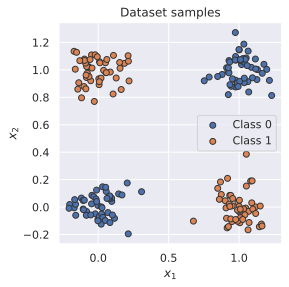

In [43]:
visualize_samples(dataset.data, dataset.label)
plt.show()

## The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch. In contrast to the dataset class, we usually don’t have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list here):

`batch_size`: Number of samples to stack per batch

`shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity.

`num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.

`persistent_workers`: If True, workers will not be shutdown after an iteration over the dataset has finished. This can be useful if the time per epoch is small, or if you face issues with workers being killed during training.

`drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

`collate_fn`: A function that defines how the elements per batch are combined. By default, PyTorch stacks them as PyTorch tensors. For JAX, we will change it to NumPy arrays.

In [ ]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


data_loader = data.DataLoader(
    dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate
)

In [53]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.92074794  0.98852634]
 [ 0.2189803   0.9191702 ]
 [-0.11832585  0.7960768 ]
 [-0.08222204  1.0243688 ]
 [-0.02176812  1.1098777 ]
 [-0.0828995   0.9439819 ]
 [-0.17131345  1.1353872 ]
 [ 1.0173181   1.0385318 ]]
Data labels (8,) 
 [0 1 1 1 1 1 1 0]


## optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader

2. Obtain the predictions from the model for the batch

3. Calculate the loss based on the difference between predictions and labels

4. Backpropagation: calculate the gradients for every parameter with respect to the loss

5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in JAX and Flax. Now, we will look at step 3 and 5.

In [54]:
import optax

Remember that we again aim to write functional code. Hence, the optimizer does not take as input the parameters, but only the optimizer hyperparameters.

In [57]:
optimizer = optax.sgd(learning_rate=0.1)

Since JAX calculates gradients via function transformations, we do not have functions like `backward()`, `optimizer.step()` or `optimizer.backward()` as in PyTorch. Instead, a optimizer is a function on the parameters and gradients. To simplify this step and bundle important parts of the training procedure, Flax offers the `flax.training` package. As a first step, we can create a `TrainState` which bundles the parameters, the optimizer, and the forward step of the model:

In [ ]:
from flax.training import train_state

model_state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)

Similar to PyTorch, Optax already provides a function for this: `optax.sigmoid_binary_cross_entropy(logits, labels)`. We calculate the loss on the logits instead of the sigmoid outputs for numerical stability. Let’s write a function that takes as input a state (for the forward function), parameters, and a batch, and return the binary cross entropy loss and accuracy:

In [ ]:
def calculate_loss_acc(state: train_state.TrainState, params, batch):
    data_input, labels = batch
    # obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

In [59]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.7000021, dtype=float32), Array(0.5, dtype=float32))

## Creating an efficient training and validation step

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state: train_state.TrainState, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(
        calculate_loss_acc,  # Function to calculate the loss
        argnums=1,  # Parameters are second argument of the function
        has_aux=True,  # Function has additional outputs, here accuracy
    )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

In [61]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

## Training

In [ ]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate
)

Now, we can write a small training function. In contrast to PyTorch, we do not need to explicitly push our model to GPU, since the parameters are already automatically created on GPU. Further, since the model itself is stateless, we do not have a train() or eval() function to switch between modes of e.g. dropout. When necessary, we can add an argument train : bool to the model forward pass. For this simple network here, however, this is not necessary.



In [63]:
def train_model(state, data_loader, num_epochs=100):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [64]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

## Saving a model


After we finished training a model, we save the model to disk so that we can load the same weights at a later time. In JAX, this means we want to save the `state.params` dictionary. Luckily, the `flax.training` package again provides us with nice utilities for that, which uses TensorFlow as underlying framework.



In [65]:
from flax.training import checkpoints

In [77]:
ckpt_path = os.path.join(os.path.abspath("."), "checkpoint")
checkpoints.save_checkpoint(
    ckpt_dir=ckpt_path,  # Folder to save checkpoint in
    target=trained_model_state,  # What to save. To only save parameters, use model_state.params
    step=100,  # Training step or other metric to save best model on
    prefix="my_model",  # Checkpoint file name prefix
    overwrite=True,  # Overwrite existing checkpoint files
)

'/home/xwc/learn_jax/uva/checkpoint/my_model100'

In [78]:
loaded_model_state = checkpoints.restore_checkpoint(
    ckpt_dir=ckpt_path,  # Folder with the checkpoints
    target=model_state,  # (optional) matching object to rebuild state in
    prefix="my_model",  # Checkpoint file name prefix
)

The states `loaded_model_state` and `trained_model_state` have the identical parameter values.

In [ ]:
print(trained_model_state, loaded_model_state)

TrainState(step=Array(2000, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of SimpleClassifierCompact(
    # attributes
    num_hidden = 8
    num_outputs = 1
)>, params={'params': {'Dense_0': {'bias': Array([-0.17559284, -0.48920417, -0.5287183 , -0.16295625, -0.2972341 ,
       -0.8991968 ,  0.56425905,  0.7840299 ], dtype=float32), 'kernel': Array([[-1.6003718 , -2.5333266 ,  1.9030163 ,  1.9110391 , -1.1925565 ,
         0.36343476,  2.7684128 , -2.774723  ],
       [-0.98069775,  1.4756805 , -3.1013336 ,  1.6899502 ,  0.5177465 ,
         1.0269188 , -1.6789845 , -2.505723  ]], dtype=float32)}, 'Dense_1': {'bias': Array([-0.06451222], dtype=float32), 'kernel': Array([[-0.80327547],
       [ 2.2827623 ],
       [ 4.2879004 ],
       [ 1.6667274 ],
       [ 0.52154434],
       [-1.5146273 ],
       [-2.8139658 ],
       [-3.318409  ]], dtype=float32)}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7f2968750b80>, update=<function c

## Evaluation

In [ ]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=numpy_collate,
)

In [ ]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a * b for a, b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [83]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


## Binding model parameters

Once we have trained the model, we might want to do multiple application of the same model and parameters. It can get a bit annoying to always write `model.apply(params, ...)` and keep track of the model and parameters separately. To prevent this, Flax’s module can be bound to specific parameters to simplify our application. Specifically, we can bind the instance `model` of our `SimpleClassifier` class to our trained parameter as follows:

In [84]:
trained_model = model.bind(trained_model_state.params)

In [85]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape

(8, 1)

## Visualizing classification boundaries


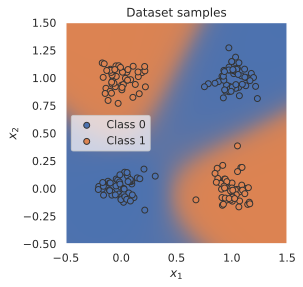

In [86]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4, 4), dpi=500)
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing="ij")  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None, None] + preds * c1[
        None, None
    ]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(
        output_image
    )  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin="lower", extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig


_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()

If we have a very limited set of different shapes, we do not see a big performance difference. For instance, in our evaluation, the last batch size is smaller than the previous since we have a limited size of the evaluation dataset. However, for other applications, we might encounter this problem much more often: NLP and time series, and graphs. In these cases, it is recommend to pad the batches to prevent many re-compilations (see Flax’s [padding guide](https://flax.readthedocs.io/en/latest/howtos/full_eval.html) for details). We briefly review the two scenarios below.